In [ ]:
pip install causal-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 2.3 MB/s eta 0:00:00


Code references:
* https://www.pywhy.org/dowhy/v0.11/example_notebooks/dowhy_causal_discovery_example.html
* https://github.com/py-why/causal-learn/issues/180
https://github.com/MIT-LCP/mimic-code/blob/main/mimic-iii/concepts/severityscores/sofa.sql
* https://causallib.readthedocs.io/en/latest/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
from google.colab import drive
from google.colab import auth
from google.cloud import bigquery
from google.colab import sheets
from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.utils.GraphUtils import GraphUtils
from sklearn.impute import KNNImputer

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
auth.authenticate_user()

In [ ]:
client = bigquery.Client(project='mimic-iv-ventilation')

In [ ]:
d_items_df = pd.read_csv('/content/drive/MyDrive/mimic-iv-clinical-database-demo-2.2/icu/d_items.csv.gz')

In [ ]:
d_lab_items_df = pd.read_csv('/content/drive/MyDrive/mimic-iv-clinical-database-demo-2.2/hosp/d_labitems.csv.gz')

In [ ]:
query = """
    SELECT DISTINCT hadm_id
    FROM `physionet-data.mimiciv_3_1_icu.icustays`
    ORDER BY FARM_FINGERPRINT(CAST(hadm_id AS STRING))
    LIMIT 15000
"""
query_job = client.query(query)
hadm_ids_df = query_job.to_dataframe()

In [ ]:
hadm_ids = hadm_ids_df['hadm_id'].tolist()

In [ ]:
hadm_ids_str = ", ".join([str(hadm_id) for hadm_id in hadm_ids])

In [ ]:
# Extract admissions info
query = f"""
    SELECT *
    FROM `physionet-data.mimiciv_3_1_hosp.admissions`
    WHERE hadm_id IN ({hadm_ids_str})
"""
query_job = client.query(query)
admissions_df = query_job.to_dataframe()

In [ ]:
# Find corresponding patient ids
patient_ids = admissions_df['subject_id'].unique()
patient_ids_str = ", ".join([str(patient_id) for patient_id in patient_ids])

In [ ]:
# Extract patients info
query = f"""
    SELECT *
    FROM `physionet-data.mimiciv_3_1_hosp.patients`
    WHERE subject_id IN ({patient_ids_str})
"""
query_job = client.query(query)
patients_df = query_job.to_dataframe()

In [ ]:
# Extract procedure events
query = f"""
    SELECT *
    FROM `physionet-data.mimiciv_3_1_icu.procedureevents`
    WHERE hadm_id IN ({hadm_ids_str})
"""
query_job = client.query(query)
procedureevents_df = query_job.to_dataframe()

In [ ]:
# Extract input events
query = f"""
    SELECT *
    FROM `physionet-data.mimiciv_3_1_icu.inputevents`
    WHERE hadm_id IN ({hadm_ids_str})
"""
query_job = client.query(query)
inputevents_df = query_job.to_dataframe()

In [ ]:
# Extract ICU stays
query = f"""
    SELECT *
    FROM `physionet-data.mimiciv_3_1_icu.icustays`
    WHERE hadm_id IN ({hadm_ids_str})
"""
query_job = client.query(query)
icustays_df = query_job.to_dataframe()

In [ ]:
# Extract ICU transfers
query = f"""
    SELECT *
    FROM `physionet-data.mimiciv_3_1_hosp.transfers`
    WHERE hadm_id IN ({hadm_ids_str}) AND careunit IN ('Medical Intensive Care Unit (MICU)','Medical/Surgical Intensive Care Unit (MICU/SICU)', 'Surgical Intensive Care Unit (SICU)', 'Cardiac Vascular Intensive Care Unit (CVICU)', 'Trauma SICU (TSICU)', 'Neuro Surgical Intensive Care Unit (Neuro SICU)')
"""
query_job = client.query(query)
transfers_df = query_job.to_dataframe()

In [ ]:
# Sort transfers df by subject, admission, and time
transfers_df = transfers_df.sort_values(by=['subject_id', 'hadm_id', 'intime'])

In [ ]:
# Filter the df for transfers
transfers_filtered = transfers_df[transfers_df['eventtype'] == 'transfer']

# Add a column for previous care unit
transfers_filtered['previous_careunit'] = transfers_filtered.groupby(['subject_id', 'hadm_id'])['careunit'].shift(1)

# Identify inter-unit transfers
interunit_transfers = transfers_filtered[transfers_filtered['careunit'] != transfers_filtered['previous_careunit']]
for i, row in interunit_transfers.iterrows():
  if pd.notna(row['previous_careunit']):
    interunit_transfers.at[i, 'transfer_occurred'] = True
  else:
    interunit_transfers.at[i, 'transfer_occurred'] = False

<ipython-input-18-9c3844de80c8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transfers_filtered['previous_careunit'] = transfers_filtered.groupby(['subject_id', 'hadm_id'])['careunit'].shift(1)
<ipython-input-18-9c3844de80c8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interunit_transfers.at[i, 'transfer_occurred'] = False


In [ ]:
# Add tranfer_occurred column to transfers_df
transfers_df = pd.merge(transfers_df, interunit_transfers, how='left')

# Change all NaN transfers to False
for i, row in transfers_df.iterrows():
  if row['transfer_occurred'] != True:
    transfers_df.at[i, 'transfer_occurred'] = False

In [ ]:
# Aggregate transfers so there is one row per admission
transfers_df = transfers_df.sort_values(by=['hadm_id', 'intime'])

# Separate into true transfers and other
true_transfers = transfers_df[transfers_df['transfer_occurred'] == True]
other_transfers = transfers_df[transfers_df['transfer_occurred'] == False]

# Keep only the first true transfer for each hadm_id
true_transfers = true_transfers.drop_duplicates(subset=['hadm_id'], keep='first')

# Take first non-transfer row for hadm_ids not in true_transfers
non_transfer_hadm_ids = set(transfers_df['hadm_id']) - set(true_transfers['hadm_id'])
filtered_other_transfers = other_transfers[other_transfers['hadm_id'].isin(non_transfer_hadm_ids)]
filtered_other_transfers = filtered_other_transfers.drop_duplicates(subset=['hadm_id'], keep='first')

# Combine the two groups
aggregated_transfers = pd.concat([true_transfers, filtered_other_transfers]).sort_values(by=['hadm_id', 'intime']).reset_index()

In [ ]:
# Extract matching data from labevents
query = f"""
    SELECT *
    FROM `physionet-data.mimiciv_3_1_hosp.labevents`
    WHERE hadm_id IN ({hadm_ids_str})
"""

query_job = client.query(query)
labevents_df = query_job.to_dataframe()

In [ ]:
# Extract diagnoses for sepsis ICD codes
query = f"""
    SELECT *
    FROM `physionet-data.mimiciv_3_1_hosp.diagnoses_icd`
    WHERE hadm_id IN ({hadm_ids_str})
"""

query_job = client.query(query)
diagnoses_df = query_job.to_dataframe()

In [ ]:
# Extract matching data from chartevents
query = f"""
    SELECT *
    FROM `physionet-data.mimiciv_3_1_icu.chartevents`
    WHERE hadm_id IN ({hadm_ids_str})
"""

query_job = client.query(query)
chartevents_df = query_job.to_dataframe()

In [ ]:
# Extract relevant chartevents for sepsis label
sepsis_chartevents = chartevents_df[chartevents_df['itemid'].isin([2200045, 223761, 223762, 220045, 220210])]

In [ ]:
# Define infection ICD codes
infection_icd_codes = ['A40', 'A41']

# Filter for patients with infection
diagnoses_df['infection'] = diagnoses_df['icd_code'].str.startswith(tuple(infection_icd_codes))
infected_patients = diagnoses_df[diagnoses_df['infection'] == True]

# List of hadm_ids for patients with sepsis infection codes
infected_hadm_ids = infected_patients['hadm_id'].unique().tolist()

In [ ]:
relevant_sepsis_chartevents = sepsis_chartevents[sepsis_chartevents['hadm_id'].isin(infected_hadm_ids)]
relevant_lab_events = labevents_df[labevents_df['hadm_id'].isin(infected_hadm_ids)]

In [ ]:
# Convert Fahrenheit to Celsius
temp_data = relevant_sepsis_chartevents[relevant_sepsis_chartevents['itemid'] == 223761]
temp_data['temp_celsius'] = (temp_data['valuenum'] - 32) * (5 / 9)
temp_data['sirs_temp'] = (temp_data['temp_celsius'] < 36) | (temp_data['temp_celsius'] > 38)

# Filter for heart rate
hr_data = relevant_sepsis_chartevents[relevant_sepsis_chartevents['itemid'] == 220045]
hr_data['sirs_hr'] = hr_data['valuenum'] > 90

# Filter for respiratory rate
rr_data = relevant_sepsis_chartevents[relevant_sepsis_chartevents['itemid'] == 220210]
rr_data['sirs_rr'] = rr_data['valuenum'] > 20

# Filter for WBC
wbc_data = relevant_lab_events[relevant_lab_events['itemid'] == 51301]
wbc_data['sirs_wbc'] = (wbc_data['valuenum'] < 4) | (wbc_data['valuenum'] > 12)

# Merge SIRS criteria
sirs_data = pd.concat([temp_data[['hadm_id', 'charttime', 'sirs_temp']],
                       hr_data[['hadm_id', 'charttime', 'sirs_hr']],
                       rr_data[['hadm_id', 'charttime', 'sirs_rr']],
                       wbc_data[['hadm_id', 'charttime', 'sirs_wbc']]], axis=0)

<ipython-input-29-47adf2701945>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data['temp_celsius'] = (temp_data['valuenum'] - 32) * (5 / 9)
<ipython-input-29-47adf2701945>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data['sirs_temp'] = (temp_data['temp_celsius'] < 36) | (temp_data['temp_celsius'] > 38)
<ipython-input-29-47adf2701945>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [ ]:
# Resample data hourly and interpolate missing values
sirs_data['charttime'] = pd.to_datetime(sirs_data['charttime'])
sirs_data = sirs_data.groupby(['hadm_id', pd.Grouper(key='charttime', freq='h')]).mean()

# Ensure only numeric columns are included in interpolation
numeric_columns = sirs_data.select_dtypes(include=['float64', 'int64']).columns
sirs_data[numeric_columns] = sirs_data[numeric_columns].interpolate(method='linear').fillna(method='ffill')

# Check for SIRS (at least 2 criteria met)
sirs_data['sirs_count'] = sirs_data[['sirs_temp', 'sirs_hr', 'sirs_rr', 'sirs_wbc']].sum(axis=1)
sirs_data['sirs_met'] = sirs_data['sirs_count'] >= 2

# Add a rolling 5-hour window to check for SIRS criteria
sirs_data['sirs_5hour'] = (
    sirs_data.groupby('hadm_id')['sirs_met']
    .transform(lambda x: x.rolling(window=5, min_periods=5).sum() >= 5)
)

# Identify sepsis onset: first time SIRS criteria are met for 5 consecutive hours
sepsis_data = sirs_data.reset_index().merge(infected_patients[['hadm_id']], on='hadm_id', how='inner')
sepsis_data = sepsis_data[sepsis_data['sirs_5hour'] == True]
sepsis_onset = sepsis_data.groupby('hadm_id')['charttime'].min().reset_index()
sepsis_onset.rename(columns={'charttime': 'sepsis_onset_time'}, inplace=True)


<ipython-input-30-fa14d935e9bb>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sirs_data[numeric_columns] = sirs_data[numeric_columns].interpolate(method='linear').fillna(method='ffill')


In [ ]:
# Create dataset for causal inference
# Initialize with hadm_id
wrangled_df = pd.DataFrame({'hadm_id': hadm_ids_df['hadm_id']})

# Add treatment variable: inter-unit ICU transfer
wrangled_df = pd.merge(wrangled_df, aggregated_transfers, on='hadm_id', how='left')

# Fill missing transfer information for non-transfers
wrangled_df['transfer_occurred'] = wrangled_df['transfer_occurred'].fillna(False)

# Add response variable: sepsis outcome
wrangled_df = pd.merge(wrangled_df, sepsis_onset, on='hadm_id', how='left')
wrangled_df['sepsis_occurred'] = ~wrangled_df['sepsis_onset_time'].isna()

# Final wrangled dataset
wrangled_df.reset_index(drop=True, inplace=True)


<ipython-input-31-10c9f808de17>:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  wrangled_df['transfer_occurred'] = wrangled_df['transfer_occurred'].fillna(False)


Extracting confounders

In [ ]:
# Merge demographics and admission details
confounders = admissions_df[['subject_id', 'hadm_id', 'admittime']].copy()
confounders = confounders.merge(patients_df[['subject_id', 'gender', 'anchor_age']], on='subject_id', how='left')

# Drop columns not needed
confounders = confounders.drop(['admittime'], axis=1)

In [ ]:
# Define comorbidity ICD code groups
comorbidities = {
    'diabetes': ['E10', 'E11'],
    'hypertension': ['I10', 'I11', 'I12'],
    'heart_disease': ['I20', 'I21', 'I22', 'I50']
}

# Add binary flags for each comorbidity
for comorbidity, codes in comorbidities.items():
    diagnoses_df[comorbidity] = diagnoses_df['icd_code'].str.startswith(tuple(codes))

# Aggregate comorbidities at the admission level
comorbidity_flags = diagnoses_df.groupby('hadm_id').agg({
    'diabetes': 'max',
    'hypertension': 'max',
    'heart_disease': 'max'
}).reset_index()


In [ ]:
# Ensure datetime columns are properly formatted
labevents_df['charttime'] = pd.to_datetime(labevents_df['charttime'])
chartevents_df['charttime'] = pd.to_datetime(chartevents_df['charttime'])
wrangled_df['sepsis_onset_time'] = pd.to_datetime(wrangled_df['sepsis_onset_time'])

# Merge sepsis onset times with lab and vital events
labevents_df = labevents_df.merge(wrangled_df[['hadm_id', 'sepsis_onset_time']], on='hadm_id', how='left')
chartevents_df = chartevents_df.merge(wrangled_df[['hadm_id', 'sepsis_onset_time']], on='hadm_id', how='left')

# Filter for labs and vitals based on sepsis onset time or lack thereof
pre_sepsis_labs = labevents_df[
    (labevents_df['sepsis_onset_time'].isna()) | (labevents_df['charttime'] <= labevents_df['sepsis_onset_time'])
]
pre_sepsis_vitals = chartevents_df[
    (chartevents_df['sepsis_onset_time'].isna()) | (chartevents_df['charttime'] <= chartevents_df['sepsis_onset_time'])
]

# Filter for relevant labs (e.g., WBC, creatinine)
lab_items = {'wbc': 51301, 'creatinine': 50912}
baseline_labs = pre_sepsis_labs[pre_sepsis_labs['itemid'].isin(lab_items.values())]
baseline_labs = baseline_labs.groupby(['hadm_id', 'itemid'])['valuenum'].mean().unstack().reset_index()
baseline_labs = baseline_labs.rename(columns=lab_items)

# Filter for relevant vitals (e.g., heart rate, respiratory rate)
vital_items = {'heart_rate': 220045, 'respiratory_rate': 220210}
baseline_vitals = pre_sepsis_vitals[pre_sepsis_vitals['itemid'].isin(vital_items.values())]
baseline_vitals = baseline_vitals.groupby(['hadm_id', 'itemid'])['valuenum'].mean().unstack().reset_index()
baseline_vitals = baseline_vitals.rename(columns=vital_items)

# Rename columns for clarity
baseline_labs.columns = ['hadm_id', 'wbc', 'creatinine']
baseline_vitals.columns = ['hadm_id', 'heart_rate', 'respiratory_rate']


In [ ]:
# Combine all confounders
confounders = confounders.merge(comorbidity_flags, on='hadm_id', how='left')
confounders = confounders.merge(baseline_labs, on='hadm_id', how='left')
confounders = confounders.merge(baseline_vitals, on='hadm_id', how='left')

# Merge with wrangled_df
wrangled_df = wrangled_df.merge(confounders, on='hadm_id', how='left')


In [ ]:
# Calculate total ICU length of stay for each admission
los = icustays_df.groupby('hadm_id')['los'].sum().reset_index()
los.rename(columns={'los': 'icu_los'}, inplace=True)

# Merge with wrangled_df
wrangled_df = wrangled_df.merge(los, on='hadm_id', how='left')


In [ ]:
# Count comorbidities for each admission
comorbidity_count = diagnoses_df.groupby('hadm_id')['icd_code'].nunique().reset_index()
comorbidity_count.rename(columns={'icd_code': 'comorbidity_count'}, inplace=True)

# Merge with wrangled_df
wrangled_df = wrangled_df.merge(comorbidity_count, on='hadm_id', how='left')

In [ ]:
# Search for antibiotics in D_ITEMS
antibiotic_items = d_items_df[d_items_df['label'].str.contains('antibiotic|antimicrobial|vancomycin|ceftriaxone', case=False, na=False)]
antibiotic_item_ids = antibiotic_items['itemid'].tolist()

# Identify first antibiotic administration time for each admission
antibiotics = inputevents_df[inputevents_df['itemid'].isin(antibiotic_item_ids)]
antibiotics_timing = antibiotics.groupby('hadm_id')['starttime'].min().reset_index()
antibiotics_timing.rename(columns={'starttime': 'first_antibiotic_time'}, inplace=True)

# Merge with wrangled_df
wrangled_df = wrangled_df.merge(antibiotics_timing, on='hadm_id', how='left')

# Antibiotics administered before sepsis
wrangled_df['antibiotics_before_sepsis'] = (
    wrangled_df['first_antibiotic_time'] < wrangled_df['sepsis_onset_time']
)
wrangled_df['antibiotics_before_sepsis'] = wrangled_df['antibiotics_before_sepsis'].fillna(False)


In [ ]:
# Search for vasopressors in D_ITEMS
vasopressor_items = d_items_df[d_items_df['label'].str.contains('norepinephrine|epinephrine|vasopressin|dopamine|dobutamine', case=False, na=False)]
vasopressor_item_ids = vasopressor_items['itemid'].tolist()

# Find the first time vasopressors were administered
vasopressor_timing = inputevents_df[inputevents_df['itemid'].isin(vasopressor_item_ids)]
vasopressor_timing = vasopressor_timing.groupby('hadm_id')['starttime'].min().reset_index()
vasopressor_timing.rename(columns={'starttime': 'first_vasopressor_time'}, inplace=True)

# Merge with wrangled_df
wrangled_df = wrangled_df.merge(vasopressor_timing, on='hadm_id', how='left')

# Add binary flags for whether vasopressors or procedures occurred
wrangled_df['vasopressor_used'] = ~wrangled_df['first_vasopressor_time'].isna()

# Vasopressors administered before sepsis
wrangled_df['vasopressor_before_sepsis'] = (
    wrangled_df['first_vasopressor_time'] < wrangled_df['sepsis_onset_time']
)
wrangled_df['vasopressor_before_sepsis'] = wrangled_df['vasopressor_before_sepsis'].fillna(False)

In [ ]:
# Search for invasive procedures in D_ITEMS
invasive_procedure_items = d_items_df[d_items_df['label'].str.contains('intubation|ventilation|central line|arterial catheter', case=False, na=False)]
invasive_procedure_item_ids = invasive_procedure_items['itemid'].tolist()

# Find the first time invasive procedures were performed
procedure_timing = procedureevents_df[procedureevents_df['itemid'].isin(invasive_procedure_item_ids)]
procedure_timing = procedure_timing.groupby('hadm_id')['starttime'].min().reset_index()
procedure_timing.rename(columns={'starttime': 'first_procedure_time'}, inplace=True)

# Merge with wrangled_df
wrangled_df = wrangled_df.merge(procedure_timing, on='hadm_id', how='left')
wrangled_df['procedure_performed'] = ~wrangled_df['first_procedure_time'].isna()

# Procedures performed before sepsis
wrangled_df['procedure_before_sepsis'] = (
    wrangled_df['first_procedure_time'] < wrangled_df['sepsis_onset_time']
)
wrangled_df['procedure_before_sepsis'] = wrangled_df['procedure_before_sepsis'].fillna(False)

In [ ]:
# Normalize continuous columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
continuous_columns = ['wbc', 'creatinine', 'heart_rate', 'comorbidity_count', 'respiratory_rate', 'icu_los', 'anchor_age']
wrangled_df[continuous_columns] = scaler.fit_transform(wrangled_df[continuous_columns])

In [ ]:
# Fill in missing values for relevant columns
categorical_columns = ['gender']
for col in categorical_columns:
    wrangled_df[col] = wrangled_df[col].fillna('Unknown')

In [ ]:
# Ensure datetime columns are in the correct format
wrangled_df['outtime'] = pd.to_datetime(wrangled_df['outtime'])
wrangled_df['sepsis_onset_time'] = pd.to_datetime(wrangled_df['sepsis_onset_time'])

# Filter rows where transfers occurred before sepsis onset
filtered_dataset = wrangled_df[
    (wrangled_df['outtime'] <= wrangled_df['sepsis_onset_time']) | wrangled_df['sepsis_onset_time'].isna()
]

# Reset the index for clarity
filtered_dataset.reset_index(drop=True, inplace=True)


In [ ]:
final_df = filtered_dataset.drop(['hadm_id', 'index', 'subject_id_x', 'transfer_id', 'eventtype', 'careunit', 'intime', 'outtime', 'previous_careunit', 'sepsis_onset_time', 'subject_id_y', 'first_antibiotic_time', 'first_vasopressor_time', 'vasopressor_used', 'first_procedure_time', 'procedure_performed'], axis=1)

In [ ]:
# Use one-hot encoding for categorical variables
final_df = pd.get_dummies(final_df, columns=['transfer_occurred', 'sepsis_occurred', 'gender', 'diabetes', 'hypertension', 'heart_disease', 'any_treatment_before_sepsis'])

# Identify redundant dummy variables ending in "_False"
redundant_columns = [col for col in final_df.columns if col.endswith('_False') or col.endswith('_M')]

# Drop redundant dummy variables
dataset = final_df.drop(columns=redundant_columns)

In [ ]:
# Impute missing values
continuous_vars = ['wbc', 'creatinine', 'respiratory_rate', 'comorbidity_count']
imputer = KNNImputer(n_neighbors=5)
dataset[continuous_vars] = imputer.fit_transform(dataset[continuous_vars])

Causal discovery using the PC algorithm

In [ ]:
corr_matrix = dataset.corr().abs()

# Select the upper triangle of the correlation matrix
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Find pairs of features with correlation = 1.0
perfectly_correlated = [
    (column, index) for column in upper_triangle.columns
    for index in upper_triangle.index
    if upper_triangle.loc[index, column] == 1.0
]

# Display the perfectly correlated pairs
print("Perfectly correlated variable pairs:")
for pair in perfectly_correlated:
    print(pair)

Perfectly correlated variable pairs:


In [ ]:
data = dataset.to_numpy()

# Convert the data to numeric
data = data.astype(float)

In [ ]:
pc_result = pc(data)

  0%|          | 0/14 [00:00<?, ?it/s]

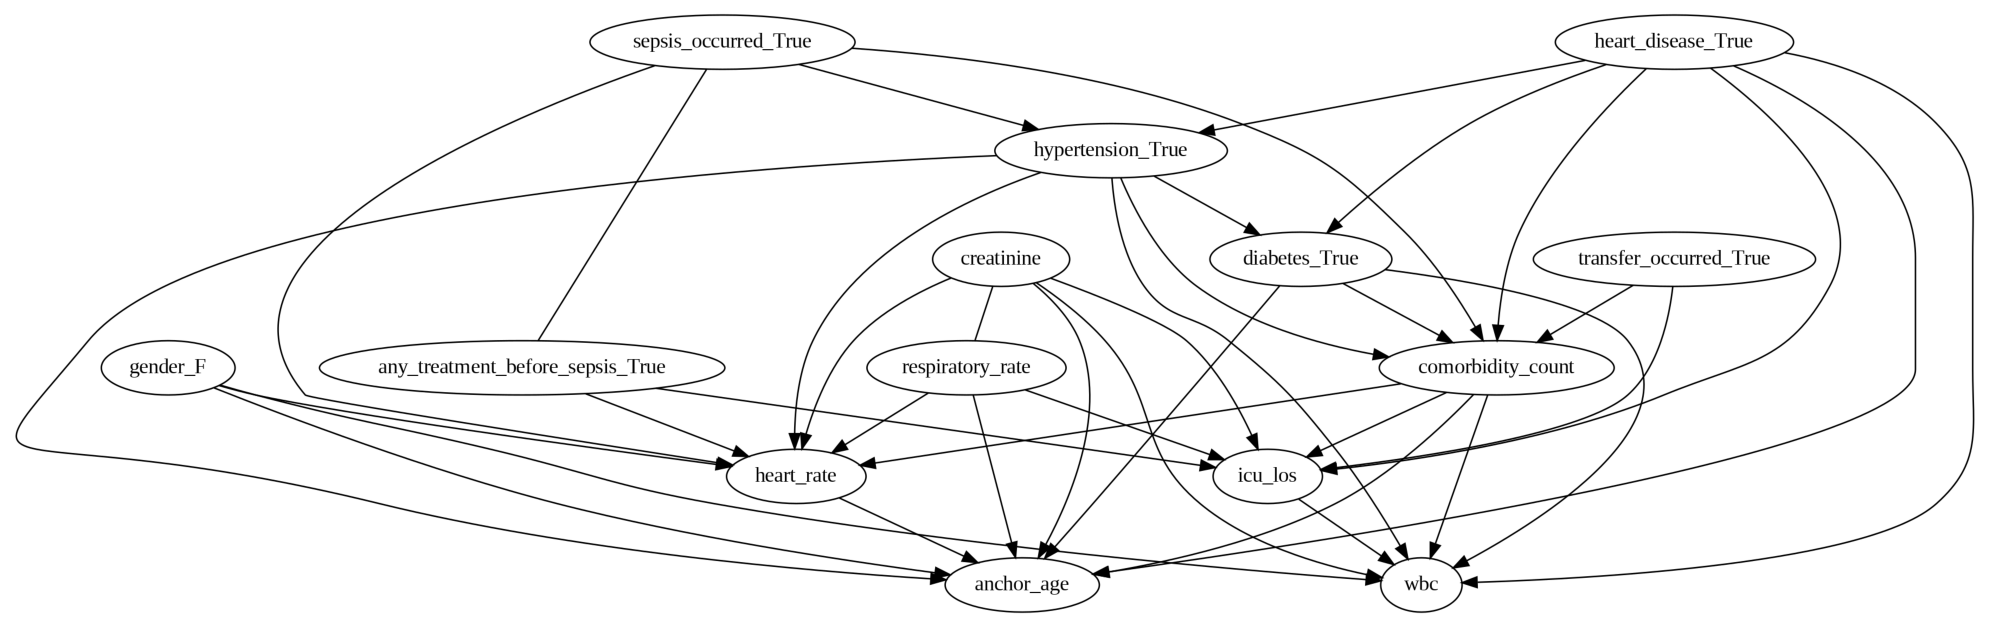

In [ ]:
# Customize labels in the graph
node_labels = {i: column_name for i, column_name in enumerate(dataset.columns)}

# Draw the graph with updated labels
pc_result.draw_pydot_graph(labels=node_labels)

In [ ]:
fci_g, fci_edges = fci(data)

  0%|          | 0/14 [00:00<?, ?it/s]

X13 --> X2
X9 --> X7
X9 --> X12
X14 --> X9


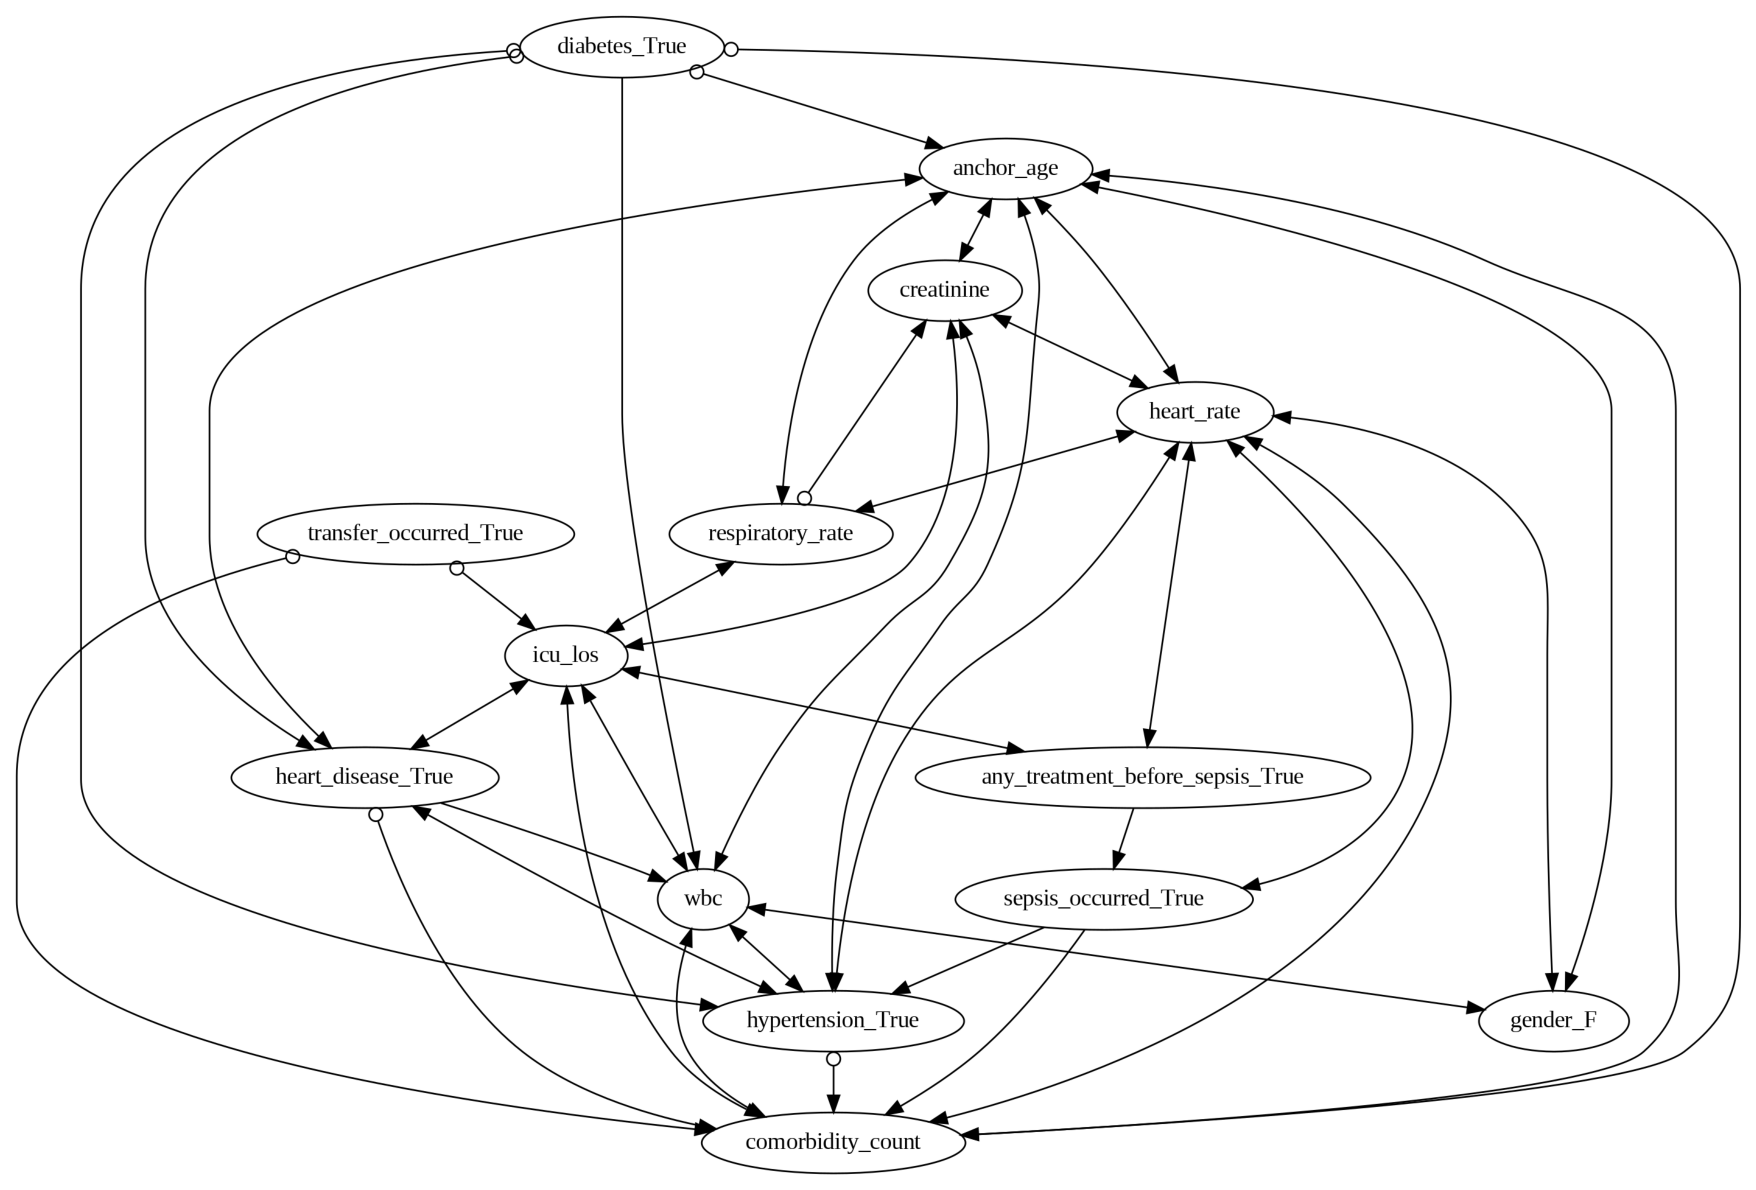

In [ ]:
pyd = GraphUtils.to_pydot(fci_g, labels=node_labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()